In [1]:
using CSV
using Plots
using DataFrames

include("Grids.jl");
using .Grids;
include("Potentials.jl")
using .Potentials;

In [2]:

r_min::Float32=-2.0;
r_max::Float32=2.0;
N::Int32=100;
l::Int32=1;
Z::Int32=1;
w::Float32=1;
m::Float32=1;


In [3]:
unif_grid= Grids.uniform_grid(r_min, r_max, N);


In [4]:
v_angu= Potentials.angular_potential(l, unif_grid);
v_colu= Potentials.coulomb_potential(Z, unif_grid);
v_harm= Potentials.harmoic_oscilator_potential(w, m, unif_grid);

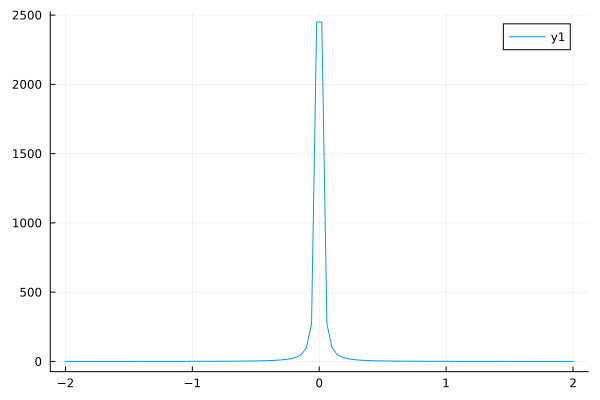

In [5]:
plot(unif_grid, v_angu)

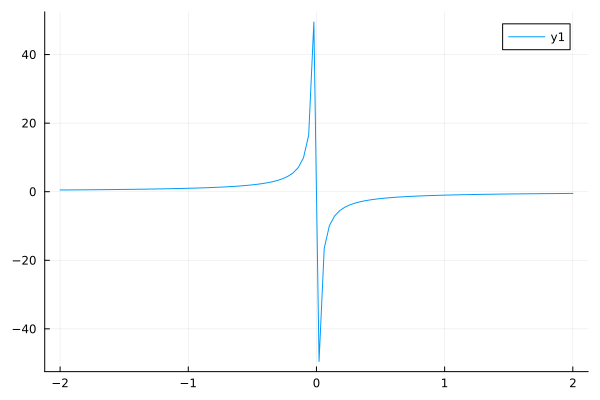

In [6]:
plot(unif_grid, v_colu)

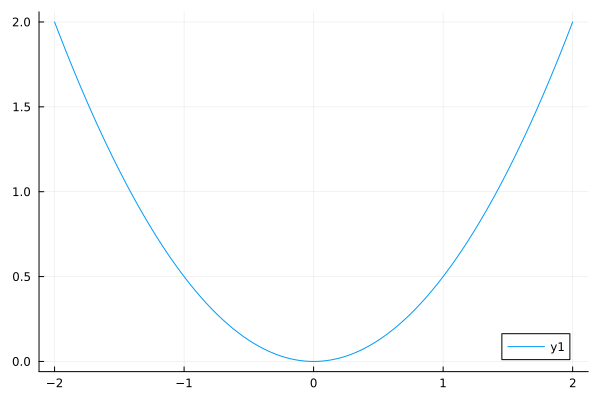

In [7]:
plot(unif_grid, v_harm)